In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from models.tree_net import TreeNet
import numpy as np

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)


# Create Dataset

In [3]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.misc
from utils.mnist import load_dataset
from utils.visualizer import Visualizer
import time

%matplotlib inline
plt.style.use('ggplot')

DS_SHAPE = [256, 256]

In [58]:
mnist = load_dataset()

In [59]:
X = np.vstack([mnist[0], mnist[2], mnist[4]])
y = np.hstack([mnist[1], mnist[3], mnist[5]])

In [ ]:
DS_SIZE = 10000
EXPECTED_NUM_DIGITS = 120
MIN_SHAPE = 8
dataset = []
targets = []

for i in range(DS_SIZE):
    if i % 100 == 0:
        print i
    img = np.zeros(DS_SHAPE, dtype=np.uint8)
    target = np.zeros([11] + DS_SHAPE, dtype=np.uint8)
    
    num_digits = np.random.poisson(EXPECTED_NUM_DIGITS)
    digits = np.random.choice(np.arange(X.shape[0]), size=num_digits)

    tlxs = np.random.randint(0, DS_SHAPE[0] - MIN_SHAPE, size=num_digits)
    tlys = np.random.randint(0, DS_SHAPE[1] - MIN_SHAPE, size=num_digits)
    
    for i in range(num_digits):
        point = np.array([tlxs[i], tlys[i]])
        
        distance = np.inf
        for j in range(num_digits):
            if i != j:
                tl = np.array([tlxs[j], tlys[j]])

                if np.linalg.norm(point - tl, ord=2) < distance:
                    if point[0] <= tl[0] or point[1] <= tl[1]:
                        distance = np.linalg.norm(point - tl, ord=2)
                        closest_point = tl
                        
        if distance == np.inf:
            closest_point = np.array(DS_SHAPE) - 1
                
        if np.abs(point - closest_point).min() < MIN_SHAPE:
            continue
            
        new_shapes = np.random.randint(MIN_SHAPE, 
                                       np.abs(point - closest_point).min() + 1,
                                       size=num_digits)
        rescaled_digit = sp.misc.imresize(X[i, 0], (new_shapes[i], new_shapes[i]))
        
        if tlxs[i] + rescaled_digit.shape[0] >= DS_SHAPE[0] - 1:
            continue
        if tlys[i] + rescaled_digit.shape[1] >= DS_SHAPE[1] - 1:
            continue
        
        img[tlxs[i] : tlxs[i] + rescaled_digit.shape[0],
            tlys[i] : tlys[i] + rescaled_digit.shape[1]] = rescaled_digit
        target[y[i],
               tlxs[i] : tlxs[i] + rescaled_digit.shape[0],
               tlys[i] : tlys[i] + rescaled_digit.shape[1]] = 1
    
    target[-1][target.sum(axis=0) == 0] = 1
    dataset.append(img)
    targets.append(target)

dataset = np.asarray(dataset)
dataset = dataset.reshape([-1, 1] + list(dataset.shape[-2:]))
targets = np.asarray(targets)

0


In [9]:
import cPickle as pickle

with open('../data/mnist_multiscale.pkl', 'wb') as f:
    pickle.dump([dataset, targets], f)

In [ ]:
plt.imshow(dataset)

# Just load dataset

In [4]:
import cPickle as pickle

with open('../data/mnist_multiscale.pkl', ) as f:
    dataset, targets = pickle.load(f)

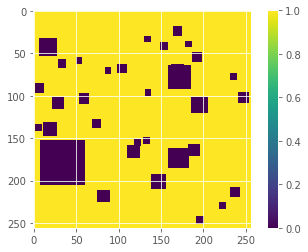

In [5]:
plt.imshow(targets[1, 10])
plt.colorbar()

# Training

In [83]:
num_cascades = 4

model = TreeNet(num_cascades, DS_SHAPE)

In [34]:
def iterate_minibatches(inputs, targets, batch_size, shuffle=True):
    indices = np.arange(len(inputs))
    
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt].astype(np.float32), targets[excerpt].astype(np.float32)


def learn(nn,
          dataset,
          watches=['obj', 'accuracy'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2].astype(np.float32), y_val[:2].astype(np.float32))
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()

In [35]:
from sklearn.model_selection import train_test_split
import lasagne
import theano
import theano.tensor as T

input_X = T.tensor4()
target_input_layer = lasagne.layers.InputLayer([None] + list(targets.shape[1:]), input_X)
mp_layer = lasagne.layers.MaxPool2DLayer(target_input_layer, 4)
downscale = theano.function([input_X], lasagne.layers.get_output(mp_layer))

downscaled_targets = []

for batch in iterate_minibatches(dataset, targets, 500, False):
    x, y = batch
    downscaled_targets.append(downscale(y).astype(np.uint8))

X_y = train_test_split(dataset, np.vstack(downscaled_targets))

In [100]:
print 1

1


<IPython.core.display.Javascript object>


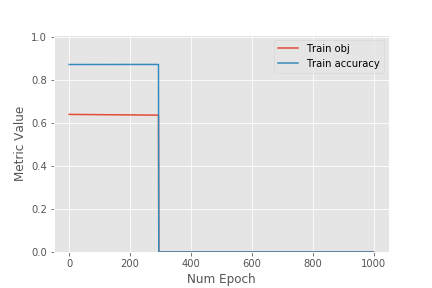

<IPython.core.display.Javascript object>


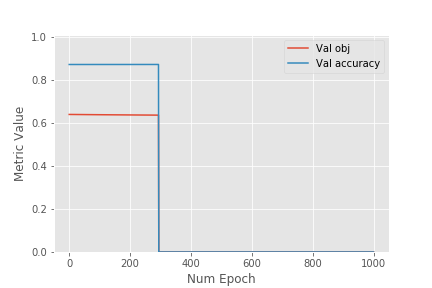

Epoch 1 of 1000 took 208.824s
Epoch 2 of 1000 took 220.438s
Epoch 3 of 1000 took 219.752s
Epoch 4 of 1000 took 220.296s
Epoch 5 of 1000 took 223.993s
Epoch 6 of 1000 took 225.264s
Epoch 7 of 1000 took 224.437s
Epoch 8 of 1000 took 224.014s
Epoch 9 of 1000 took 223.514s
Epoch 10 of 1000 took 224.137s
Epoch 11 of 1000 took 224.712s
Epoch 12 of 1000 took 221.286s
Epoch 13 of 1000 took 220.062s
Epoch 180 of 1000 took 218.564s
Epoch 181 of 1000 took 219.372s
Epoch 182 of 1000 took 220.176s
Epoch 183 of 1000 took 219.102s
Epoch 184 of 1000 took 219.393s
Epoch 199 of 1000 took 218.478s
Epoch 200 of 1000 took 219.119s
Epoch 201 of 1000 took 218.903s
Epoch 202 of 1000 took 218.567s
Epoch 203 of 1000 took 218.765s
Epoch 204 of 1000 took 219.273s
Epoch 205 of 1000 took 220.034s
Epoch 206 of 1000 took 218.038s
Epoch 207 of 1000 took 217.707s
Epoch 208 of 1000 took 218.519s
Epoch 209 of 1000 took 218.569s
Epoch 210 of 1000 took 218.655s
Epoch 211 of 1000 took 218.035s
Epoch 212 of 1000 took 218.149

In [ ]:
learn(model, X_y, num_epochs=1000, batch_size=100)

In [98]:
print 1

1


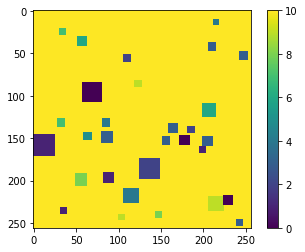

In [40]:
%matplotlib inline
plt.imshow(np.argmax(targets[0], axis=0))
plt.colorbar()

In [94]:
model.train(X_y[0][:100], X_y[-2][:100])

{'accuracy': array(0.8486279296875),
 'obj': array(1.583815574645996, dtype=float32)}

In [95]:
model.train(X_y[0][:100], X_y[-2][:100])

{'accuracy': array(0.8486474609375),
 'obj': array(1.5834221839904785, dtype=float32)}

In [62]:
model.train(X_y[0][:100], X_y[-2][:100])

{'accuracy': array(0.87248291015625),
 'obj': array(-0.7806107401847839, dtype=float32)}

In [50]:
model.train = model.compile_trainer(1e-2, lasagne.updates.adamax)

In [56]:
targets[:, 10, :, :].sum() / (256 ** 2) / 10000.

0.90740065612792964

In [64]:
X_y[-2][:, 10, :, :].sum() / 7500. / 64. / 64.

0.93709498697916671

In [63]:
X_y[-2][:, 10, :, :].shape

(7500, 64, 64)

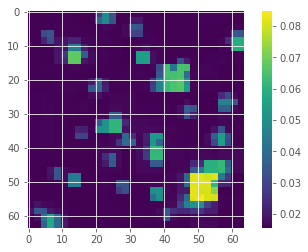

In [113]:
%matplotlib inline

prediction = model.predict(X_y[1][:100])
plt.imshow(prediction[0][8])

plt.colorbar()

In [79]:
from lasagne.layers import get_output

result_classes = model.upscale_and_mul(get_output(model.net['classifier_0']),
                                      get_output(model.net['o0'])[:, 0, :, :])
result_nothing = lasagne.layers.get_output(model.net['o0'])[:, 1, :, :]

for i in range(1, model.num_cascades):
    decision = lasagne.layers.get_output(model.net['o{}'.format(i - 1)])

    p_classify = decision[:, 0, :, :]
    p_stop = decision[:, 1, :, :]
    p_continue = decision[:, 2, :, :]

    for j in range(i - 1):
        new_p_continue = get_output(model.net['o{}'.format(j)])[:, 2, :, :]
        p_continue = model.upscale_and_mul(new_p_continue, p_continue)

    p_local_stop = model.upscale_and_mul(p_continue,
                                         get_output(model.net['o{}'.format(i)])[:, 1, :, :])
    p_stop = model.upscale_and_add(
        p_stop,
        p_local_stop
    )

    p_class = model.upscale_and_mul(get_output(model.net['classifier_{}'.format(i)]),
                                   get_output(model.net['o{}'.format(i)])[:, 0, :, :])

    p_local_class = model.upscale_and_mul(p_continue, p_class)
    result_classes = model.upscale_and_add(result_classes,
                                          p_local_class)
    result_nothing = model.upscale_and_add(result_nothing,
                                           p_stop)

In [87]:
prediction = model.predict(X_y[1][:100])

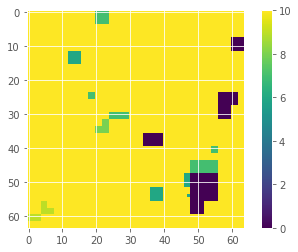

In [91]:
plt.imshow(np.argmax(prediction[0], axis=0))
plt.colorbar()

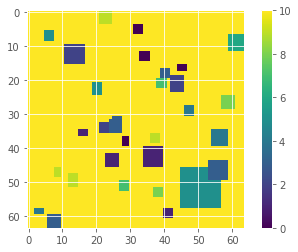

In [92]:
plt.imshow((np.argmax(X_y[-1][:100][0], axis=0)))
plt.colorbar()